In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import imshow, imread, imsave
import seaborn as sns
from skimage.color import rgb2gray
import geopandas as gpd
from keras.models import load_model
from keras import backend as K
import rasterio as rio

#os.chdir('data/Smart-Farming/')
os.chdir('../')

from notebooks.assets.data_generators import Segmentation_DataGenerator
from notebooks.assets.evaluation import Segmentation_Evaluation
from notebooks.assets.data_interface import Dataset, Data_Interface
from notebooks.assets.unet import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
Seed_Masks = {}
for c_value in range(1, 15):
        Seed_Masks["c_" + str(c_value)] = gpd.read_file("data/shapes/C_{}.shp".format(c_value)).to_crs({'init': 'epsg:32632', 'units' : 'm'})
        
Fields = {
        'field_A' : gpd.read_file("data/shapes/variante_A.shp").to_crs({'init': 'epsg:32632',
                                                                                    'units' : 'm'}),
        'field_B' : gpd.read_file("data/shapes/variante_B.shp").to_crs({'init': 'epsg:32632',
                                                                                                     'units' : 'm'}),
        'field_C' : gpd.read_file("data/shapes/variante_C.shp").to_crs({'init': 'epsg:32632',
                                                                                                     'units' : 'm'})
}

In [5]:
pred = rio.open("data/exports/20190719/prediction_A.tif")
dsm = rio.open("data/rasters/20190719/dsm.tif")

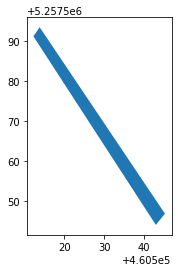

In [6]:
intersection = gpd.overlay(Fields['field_A'], Seed_Masks['c_14'], how='intersection')
intersection.plot()

In [7]:
shapes = [feature.geometry for i, feature in intersection.iterrows()]

In [8]:
out_pred, transform_pred = rio.mask.mask(pred, shapes, crop=True)
out_dsm, transform_dsm = rio.mask.mask(dsm, shapes, crop=True)
out_pred = np.moveaxis(out_pred, 0, -1)
out_dsm = out_dsm.squeeze()

In [9]:
from skimage.transform import rescale, resize
out_dsm = resize(out_dsm, out_pred.shape[0:2])

In [10]:
assert out_dsm.shape == out_pred.shape[0:2], "shapes dont match"
print(out_dsm.shape)

(6176, 4110)


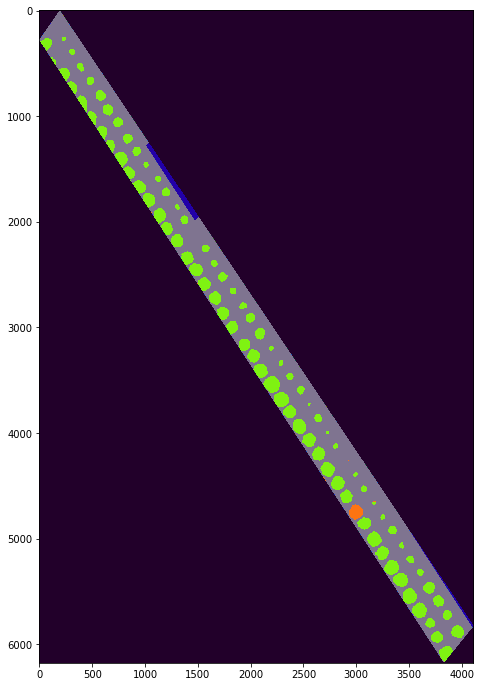

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(out_dsm)
plt.imshow(out_pred, alpha=0.5)

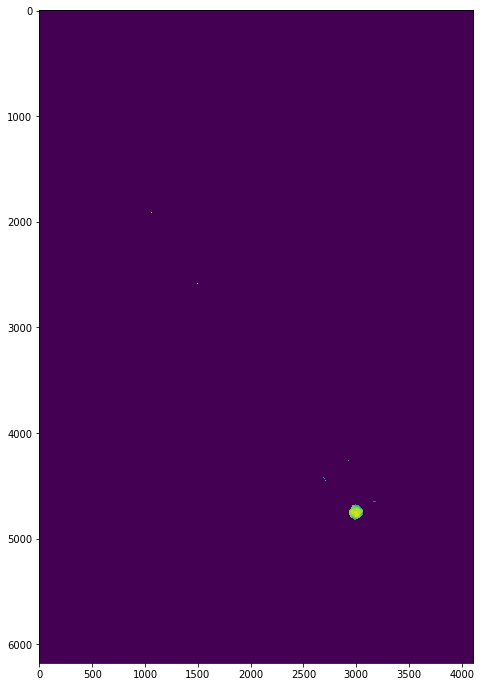

In [12]:
plt.figure(figsize=(12, 12))
masked_dsm = out_dsm.copy()
species = 0
for i in range(out_pred.shape[-1]):
        if i == species:
            continue
        masked_dsm[out_pred[..., i] > 0] = 0
masked_dsm = np.clip(masked_dsm, a_min=0, a_max=None)
plt.imshow(masked_dsm)

In [13]:
intersection.area[0]

168.46994040268868

In [14]:
masked_dsm.max()

1.0003622

In [29]:
new_Seed_Masks = {}
new_Seed_Masks['c_1_2'] = gpd.overlay(Seed_Masks['c_1'], Seed_Masks['c_2'], how='union')
new_Seed_Masks['c_3_4'] = gpd.overlay(Seed_Masks['c_3'], Seed_Masks['c_4'], how='union')
new_Seed_Masks['c_5_6'] = gpd.overlay(Seed_Masks['c_5'], Seed_Masks['c_6'], how='union')
new_Seed_Masks['c_7_8'] = gpd.overlay(Seed_Masks['c_7'], Seed_Masks['c_8'], how='union')
new_Seed_Masks['c_9_10'] = gpd.overlay(Seed_Masks['c_9'], Seed_Masks['c_10'], how='union')
new_Seed_Masks['c_11_12'] = gpd.overlay(Seed_Masks['c_11'], Seed_Masks['c_12'], how='union')
new_Seed_Masks['c_13_14'] = gpd.overlay(Seed_Masks['c_13'], Seed_Masks['c_14'], how='union')

In [43]:
def calc_volume(prediction_tif, dsm_tif, field_shape , seed_shape, species):
    intersection = gpd.overlay(field_shape, seed_shape, how='intersection')
    shapes = [feature.geometry for i, feature in intersection.iterrows()]
    
    out_pred, transform_pred = rio.mask.mask(prediction_tif, shapes, crop=True)
    out_dsm, transform_dsm = rio.mask.mask(dsm_tif, shapes, crop=True)
    out_pred = np.moveaxis(out_pred, 0, -1)
    out_dsm = out_dsm.squeeze()
    
    out_dsm = resize(out_dsm, out_pred.shape[0:2])
    assert out_dsm.shape == out_pred.shape[0:2], "shapes dont match"
    
    masked_dsm = out_dsm.copy()
    for i in range(out_pred.shape[-1]):
        if i == species:
            continue
        masked_dsm[out_pred[..., i] > 0] = 0
    masked_dsm = np.clip(masked_dsm, a_min=0, a_max=None)
    
    #hemp_area = np.sum(masked_dsm > 0)*transform_pred[0]*transform_pred[4]*-1
    
    hemp_area = masked_dsm.sum()*transform_pred[0]*transform_pred[4]*-1
    
    return 100 * hemp_area / intersection.area.sum(), intersection.area.sum()
    
calc_volume(rio.open("data/exports/" + '20190719' + "/" + 'prediction_A.tif'), 
            rio.open("data/rasters/" + '20190719' + "/dsm.tif"), Fields['field_A'], new_Seed_Masks['c_1_2'], 1)

(3.1699793997681076, 345.14620959106503)

In [44]:
df = pd.DataFrame(columns={'date', 'field', 'seed', 'species', 'hemp_volume_per_100m2', 'area'})

for date in ['20190703', '20190719', '20190822']:
    dsm = rio.open("data/rasters/" + date + "/dsm.tif")
    for raster_field_key, shape_field_key in zip(['prediction_A.tif', 'prediction_B.tif'], ['field_A', 'field_B']):
        for seed_key, seed_value in new_Seed_Masks.items():
            for i, species in enumerate(['1001', '1005']):
                hemp_volume, area = calc_volume(rio.open("data/exports/" + date + "/" + raster_field_key), dsm, Fields[shape_field_key], seed_value, i)
                
                df = df.append({'date': date[4:],
                                'field': shape_field_key,
                                'seed': seed_key,
                                'species': species,
                                'hemp_volume_per_100m2': hemp_volume,
                                'area': area},
                                ignore_index=True)

In [45]:
gpd.overlay(Fields['field_A'], new_Seed_Masks['c_11_12'], how='intersection').area.sum()

331.19242012364623

In [50]:
df.to_csv('data/volume_calculation.csv')

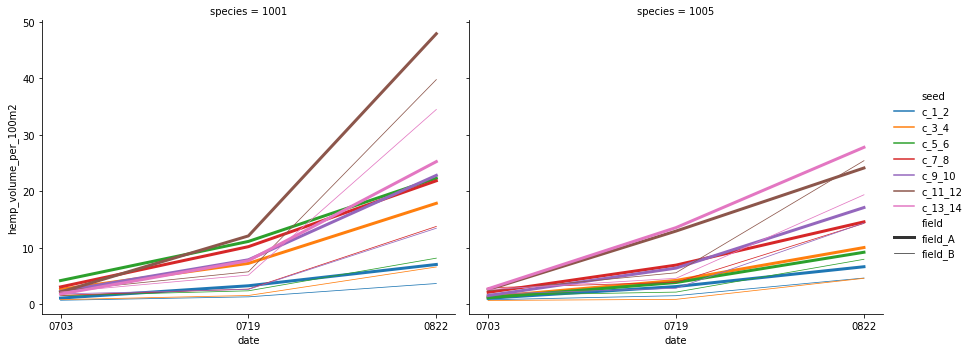

In [144]:
# Plot the lines on two facets
sns.relplot(x="date", y="hemp_volume_per_100m2",
            hue="seed", size="field", col="species",
            height=5, aspect=1.25, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=df)

Text(0.5, 1, 'Species 1005, Field B')

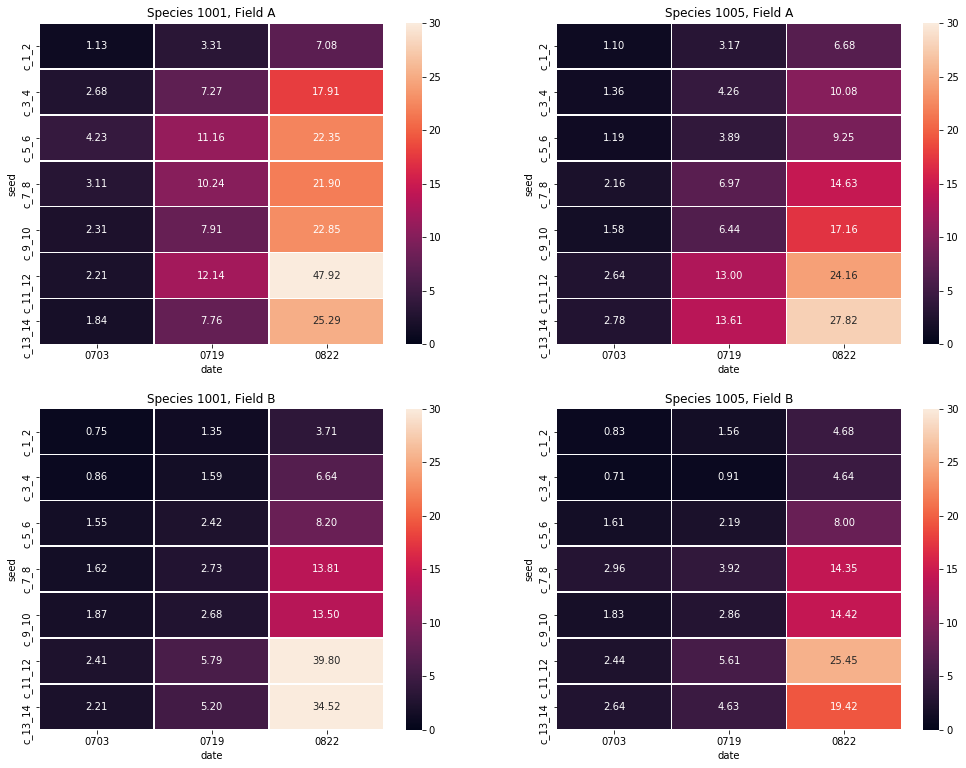

In [141]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(2, 2, figsize=(17, 13))

tmp = df.loc[(df['species'] == '1001') & (df['field'] == 'field_A')]
tmp = tmp.pivot('seed', 'date', 'hemp_volume_per_100m2')
tmp = tmp.reindex(["c_1_2", "c_3_4", "c_5_6", "c_7_8", "c_9_10", "c_11_12", "c_13_14"])
sns.heatmap(tmp, annot=True, fmt=".2f", linewidths=.5, ax=ax[0, 0], vmin=0, vmax=30)
ax[0, 0].set_title("Species 1001, Field A")

tmp = df.loc[(df['species'] == '1005') & (df['field'] == 'field_A')]
tmp = tmp.pivot('seed', 'date', 'hemp_volume_per_100m2')
tmp = tmp.reindex(["c_1_2", "c_3_4", "c_5_6", "c_7_8", "c_9_10", "c_11_12", "c_13_14"])
sns.heatmap(tmp, annot=True, fmt=".2f", linewidths=.5, ax=ax[0, 1], vmin=0, vmax=30)
ax[0, 1].set_title("Species 1005, Field A")

tmp = df.loc[(df['species'] == '1001') & (df['field'] == 'field_B')]
tmp = tmp.pivot('seed', 'date', 'hemp_volume_per_100m2')
tmp = tmp.reindex(["c_1_2", "c_3_4", "c_5_6", "c_7_8", "c_9_10", "c_11_12", "c_13_14"])
sns.heatmap(tmp, annot=True, fmt=".2f", linewidths=.5, ax=ax[1, 0], vmin=0, vmax=30)
ax[1, 0].set_title("Species 1001, Field B")

tmp = df.loc[(df['species'] == '1005') & (df['field'] == 'field_B')]
tmp = tmp.pivot('seed', 'date', 'hemp_volume_per_100m2')
tmp = tmp.reindex(["c_1_2", "c_3_4", "c_5_6", "c_7_8", "c_9_10", "c_11_12", "c_13_14"])
sns.heatmap(tmp, annot=True, fmt=".2f", linewidths=.5, ax=ax[1, 1], vmin=0, vmax=30)
ax[1, 1].set_title("Species 1005, Field B")